# GLM @ KTH 

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import glm
import re
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Read data
* Provided data in Cancellation.csv is read into a table
* Note that the folder in which you have Cancellation.csv must be set as the working directory
* You don't need to change anything in this section

In [33]:
df = pd.read_csv(
    r"Cancellation.csv",
    sep=";",
    decimal=".",
)

In [34]:
# Initial check on number of rows and columns
n_rows = df.shape[0]
n_columns = df.shape[1]
print(f"Number iof rows: {n_rows}\nNumber of columns: {n_columns}")

Number iof rows: 136893
Number of columns: 14


In [35]:
# Initial display of the data frame
df

,DurStart,DurEnd,RiskYear,Duration,NumberOfClaims,ClaimCost,NumberOfFtEmployees,CompanyAge,TravellingArea,DangerousAreas,NumberOfPersons,FinancialRating,ID,ActivityCode
0,2019-11-01,2019-12-31,2019,0.166667,0,0.0,30,13.526027,Abroad (whole world),Excluded,16.0,AA,3.990000e+12,N
1,2020-01-01,2020-02-23,2020,0.147541,0,0.0,0,0.000000,Abroad (whole world),Excluded,16.0,Missing,3.990000e+12,N
2,2020-02-24,2020-07-24,2020,0.415301,0,0.0,0,0.000000,Abroad (whole world),Excluded,16.0,Missing,4.550000e+12,N
3,2020-07-25,2020-09-21,2020,0.161644,0,0.0,0,0.000000,Abroad (whole world),Excluded,16.0,Missing,4.720000e+12,N
4,2016-07-01,2016-12-31,2016,0.504110,0,0.0,10,8.304110,Abroad (whole world),Excluded,9.0,C,1.910000e+12,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136888,2017-01-01,2017-07-14,2017,0.534247,0,0.0,2,1.638356,In one's home country,Excluded,3.0,AN,2.090000e+12,H
136889,2017-07-15,2017-12-31,2017,0.465753,0,0.0,2,1.638356,In one's home country,Excluded,3.0,AN,2.400000e+12,H
136890,2018-01-01,2018-07-14,2018,0.534247,0,0.0,2,2.638356,In one's home country,Excluded,3.0,B,2.400000e+12,H
136891,2018-07-15,2018-12-31,2018,0.465753,0,0.0,2,2.638356,In one's home country,Excluded,3.0,B,3.530000e+12,H


# Exploration
* Check distribution of average claim size and number of claims
* Check if claim cost and number of claims vary between risk years

In [36]:
df["AvgClaimCost"] = df["ClaimCost"] / df["NumberOfClaims"]

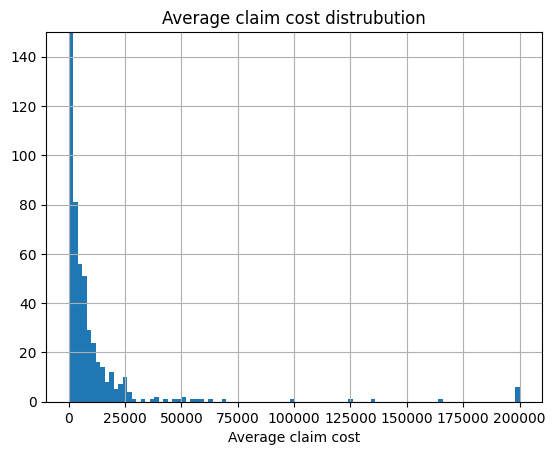

In [37]:
df["AvgClaimCost"].hist(bins=100)
plt.ylim((0, 150))  # limit y-axis due to high density at 0
plt.xlabel("Average claim cost")
plt.title("Average claim cost distrubution")
plt.show()

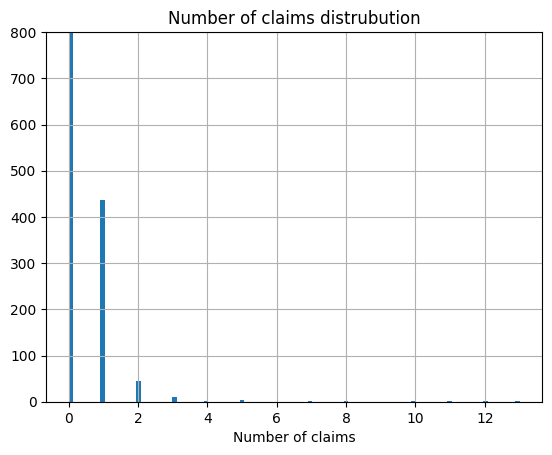

In [38]:
df["NumberOfClaims"].hist(bins=100)
plt.ylim((0, 800))  # limit y-axis due to high density at 0
plt.xlabel("Number of claims")
plt.title("Number of claims distrubution")
plt.show()

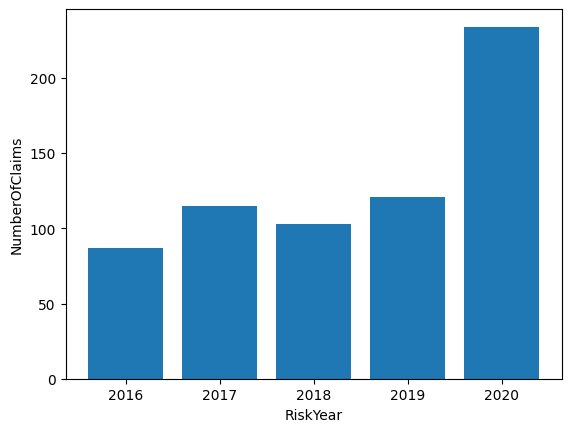

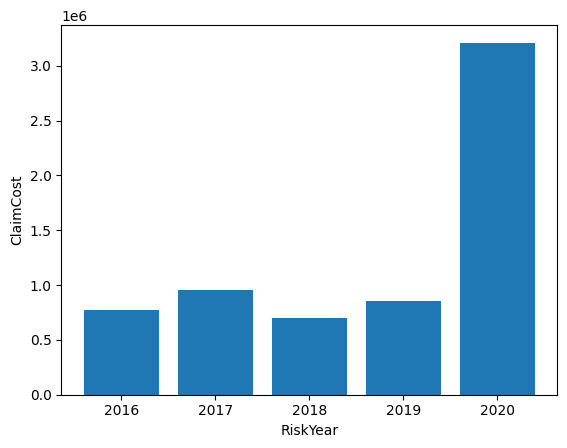

In [39]:
# Aggregate per RiskYear to see development over time
agg_dict = {"NumberOfClaims": "sum", "ClaimCost": "sum"}
df_agg_ry = df.groupby("RiskYear").agg(agg_dict)

for var in agg_dict:
    plt.bar(df_agg_ry.index, df_agg_ry[var])
    plt.xlabel(df_agg_ry.index.name)
    plt.ylabel(var)
    plt.show()

# Preprocess data
Now you need to modify your data so that you can perform a GLM analysis.

1. Missing values need to be handeled
2. Any continuous variable you want to use needs to be grouped into discrete groups
3. Categorical variables can be grouped even more

Below, there are examples on how to handle missing variables, how to group numerical variables and how to group categorical varaibles further.

### Handle missing values
If some variables are missing data for some rows, how do we handle this? Some alternatives:
* Make a "missing" group
* Fill numerical values with mean or median
* Fill with most common value

In [40]:
fill_missing_with = {"NumberOfPersons": 0}

for var in fill_missing_with:
    df.loc[df[var].isna(), var] = fill_missing_with[var]

grouping_map = {
    "Abroad (whole world)": "world",
    "Abroad in Europe": "eu",
    "Abroad in Nordic Country": "nordic",
    "In one's home country": "home",
}
df['TravellingArea'] = df['TravellingArea'].replace(to_replace=grouping_map)
data = df.copy()

In [41]:
df["Frequency"] = df["NumberOfClaims"] / df["Duration"]
df["Yearly ClaimCost"] = df["ClaimCost"] / df["Duration"]

## Grouping
The groupings below are only examples, you need to create your own groups, with breaks that suit your data.

For example visualize the data for the different variables and refer to the information in the Appendix group the Activity codes on similar types of business.

Remember to think about risk homogeneous and stable groups, for example having groups with zero number of caims or claims cost and almost no Duration makes it hard to determine its risk.

You might also want to group other variables from glmdata, in a similar manner

### Group numerical variables
When grouping numerical variables we can specify the group edges and labels, and then let pandas cut()-function do the job.

It is important that there are claims and claim cost in each resulting group. Therefore it is always a good idea to check some statistics after doing the grouping.

In [42]:
# Define the variable that is going to be grouped, the name of the new (grouped) variable, group/bin edges and labels
variable = "NumberOfPersons"
grouped_variable_name = "NoPGroup"
bin_edges = [-np.inf, 2, 5, 15, 50, 100, np.inf]
bin_labels = ["01. <2", "02. 2-4", "03. 5-14", "04. 15-49", "05. 50-99", "06. >=100"]

# This part does the grouping based on the input above
df[grouped_variable_name] = pd.cut(
    df[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=False,  # Wheter to include the right edge in group or not
)

#### Check on the resulting groups
- Make sure there are claims in each group
- Plot frequency, severity, claim cost and duration per group to see the marginal factors and how much duration we have in each group

In [43]:
def checkgroup(grouped_variable_name, data=df):
    # How to aggregate the data to see how many rows, claims and how much claim cost there is in each category
    aggregations = {
        "ID": "count",  # ID used here to calculate how many rows of data are in each category
        "Duration": "sum",
        "NumberOfClaims": "sum",
        "ClaimCost": "sum",
    }

    # Renaming of Duration in aggregation due to using this col for counting
    renamings = {"ID": "NumberOfRows"}

    # Do the aggregation and renamning
    df_agg_stat = (
        data.groupby(grouped_variable_name).agg(aggregations).rename(columns=renamings)
    )

    # Display the aggregated data
    print(df_agg_stat)

    fig = plt.figure(figsize=(25, 5))

    plt.subplot(141)
    plt.xlabel(df_agg_stat.index.name)
    plt.bar(df_agg_stat.index, df_agg_stat["NumberOfClaims"] / df_agg_stat["Duration"])
    plt.title("Frequency")

    plt.subplot(142)
    plt.xlabel(df_agg_stat.index.name)
    plt.bar(df_agg_stat.index, df_agg_stat["ClaimCost"] / df_agg_stat["NumberOfClaims"])
    plt.title("AvgClaimCost")

    plt.subplot(143)
    plt.xlabel(df_agg_stat.index.name)
    plt.bar(df_agg_stat.index, df_agg_stat["ClaimCost"] / df_agg_stat["Duration"])
    plt.title("Yearly ClaimCost")

    plt.subplot(144)
    plt.xlabel(df_agg_stat.index.name)
    plt.bar(df_agg_stat.index, df_agg_stat["Duration"])
    plt.title("Duration")

    plt.show()

           NumberOfRows      Duration  NumberOfClaims   ClaimCost
NoPGroup                                                         
01. <2            25661  12144.287948              40   162369.00
02. 2-4           56200  27041.206917             113   725059.74
03. 5-14          31884  15111.614485             137  1362309.36
04. 15-49         15656   7492.322449             134  1357217.12
05. 50-99          3527   1774.073531              54   755934.00
06. >=100          3965   2554.897724             182  2131658.61


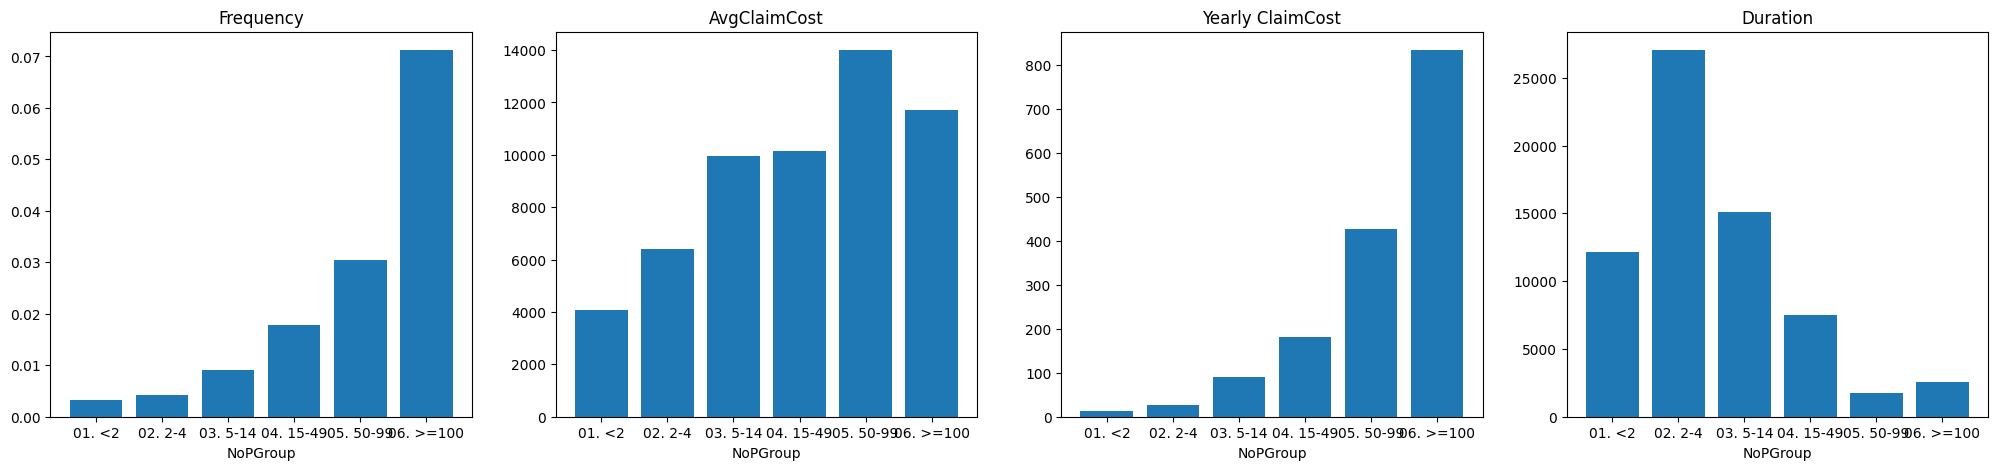

In [44]:
checkgroup("NoPGroup")

### Group categorical variables
When grouping categorical variables we can for each current category specify the new category, and then let pandas replace()-function do the job.

As for numerical variables, it is important that there are claims and claim cost in each resulting group. Therefore it is always a good idea to check some statistics after doing the grouping.

In [45]:
# Define the variable that is going to be grouped, the name of the new (grouped) variable and grouping map
variable = "ActivityCode"
grouped_variable_name = "ActivityGroup"
# grouping_map structure: {current category : new category}
act_grouping_map = {
    "A": "Industry",
    "B": "Industry",
    "C": "Industry",
    "D": "Industry",
    "E": "Industry",
    "F": "Industry",
    "G": "Service",
    "H": "Service",
    "I": "Service",
    "J": "Other",
    "K": "Other",
    "L": "Other",
    "M": "Other",
    "N": "Other",
    "O": "Other",
    "P": "Other",
    "Q": "Service",
    "R": "Other",
    "S": "Service",
    "T": "Service",
    "U": "Industry",
    "X": "Industry",
    "Missing": "Industry",
}

# This part does the grouping based on the input above
df[grouped_variable_name] = df[variable].replace(to_replace=act_grouping_map)

               NumberOfRows      Duration  NumberOfClaims   ClaimCost
ActivityGroup                                                        
Industry              30706  14652.543027              73   468134.43
Other                 72106  34872.417688             356  4289336.94
Service               34081  16593.442339             231  1737076.46


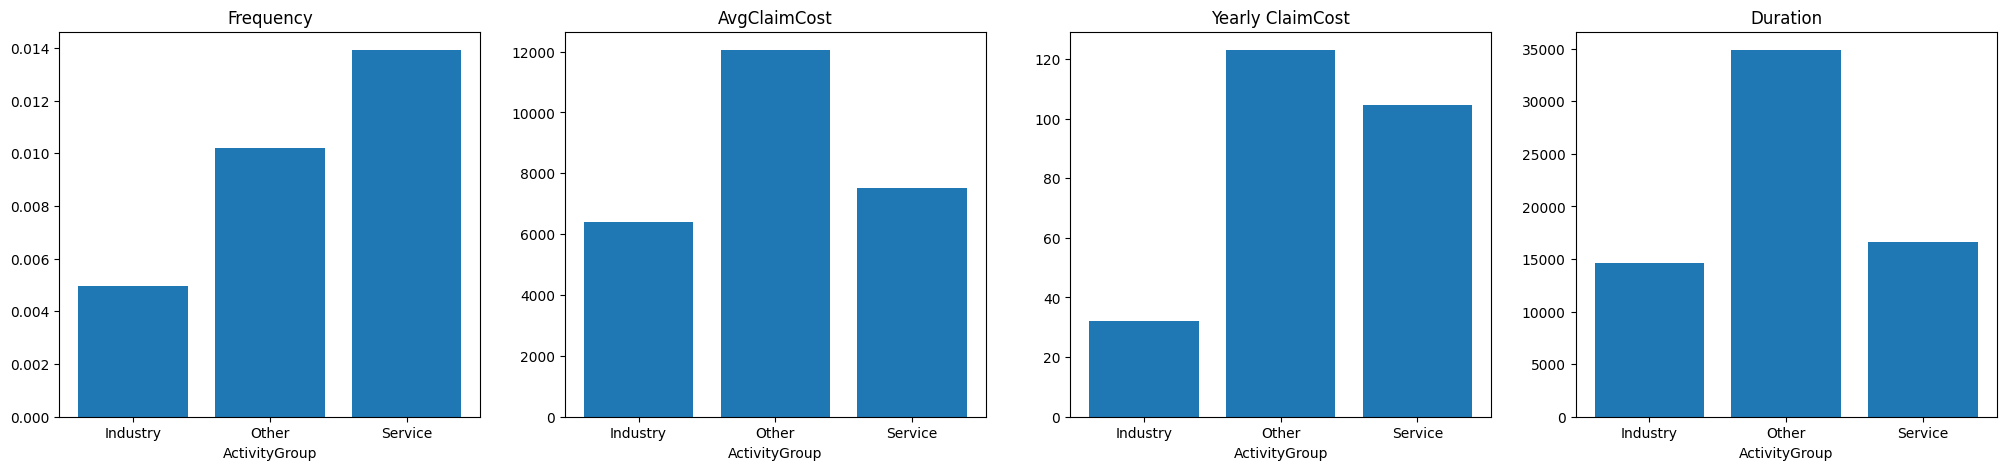

In [46]:
checkgroup("ActivityGroup")

#### Check on the resulting groups
- Make sure there are claims in each group
- Plot frequency, severity, claim cost and duration per group to see the marginal factors and how much duration we have in each group

          NumberOfRows      Duration  NumberOfClaims   ClaimCost
AgeGroup                                                        
1                84209  40057.362310             380  4260616.70
2                39758  19492.741822             168  1273951.77
3                11292   5692.605764             107   940304.36
4                 1634    875.693158               5    19675.00


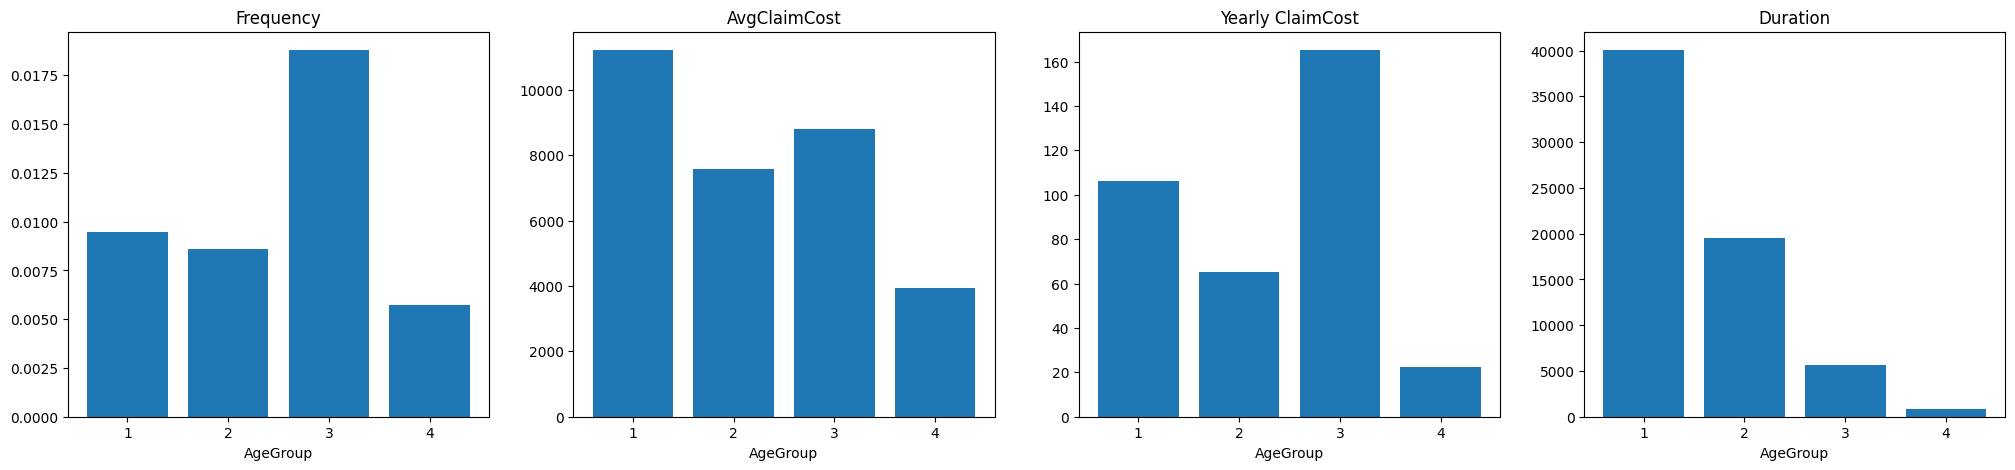

In [47]:
variable = "CompanyAge"
grouped_variable_name = "AgeGroup"
bin_edges = [-np.inf, 10, 30, 60, np.inf]
bin_labels = [str(i) for i in range(1, len(bin_edges))]

# This part does the grouping based on the input above
df[grouped_variable_name] = pd.cut(
    df[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=False,  # Wheter to include the right edge in group or not
)
checkgroup("AgeGroup")

          NumberOfRows      Duration  NumberOfClaims   ClaimCost
FinGroup                                                        
A                65747  31996.419440             479  5254903.17
AA-B             59410  28609.525129             165  1155072.16
C                11736   5512.458485              16    84572.50


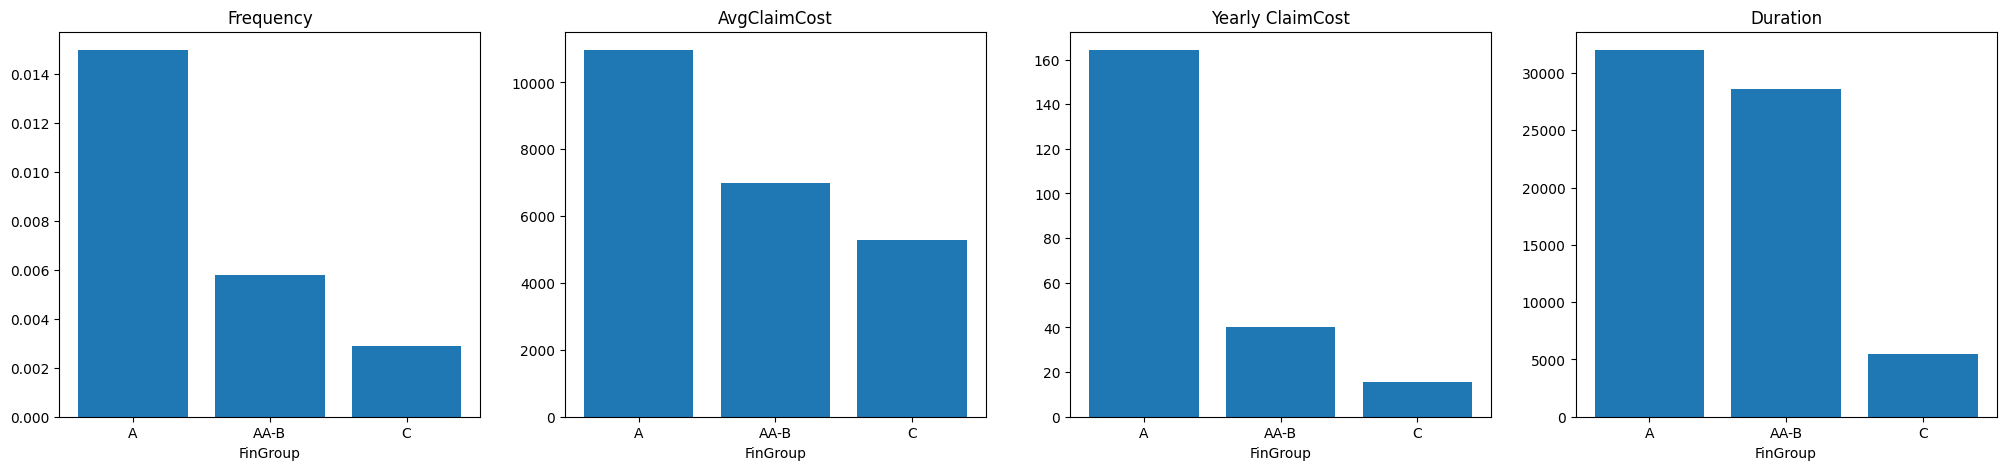

In [48]:
grouping_map = {
    "AAA" : "A",
    "AA" : "AA-B",
    "A" : "AA-B",
    "B" : "AA-B",
    "C" : "C",
    "AN": "C",
    "IR": "C",
    "Missing": "A",
}
df["FinGroup"] = df["FinancialRating"].replace(grouping_map)
checkgroup("FinGroup",df)

           NumberOfRows      Duration  NumberOfClaims   ClaimCost
NofeGroup                                                        
1                128274  61875.958987             502  4968764.22
2                  4745   2275.473396              48   442432.50
3                  2069   1012.227345              41   430120.61
4                  1805    954.743327              69   653230.50


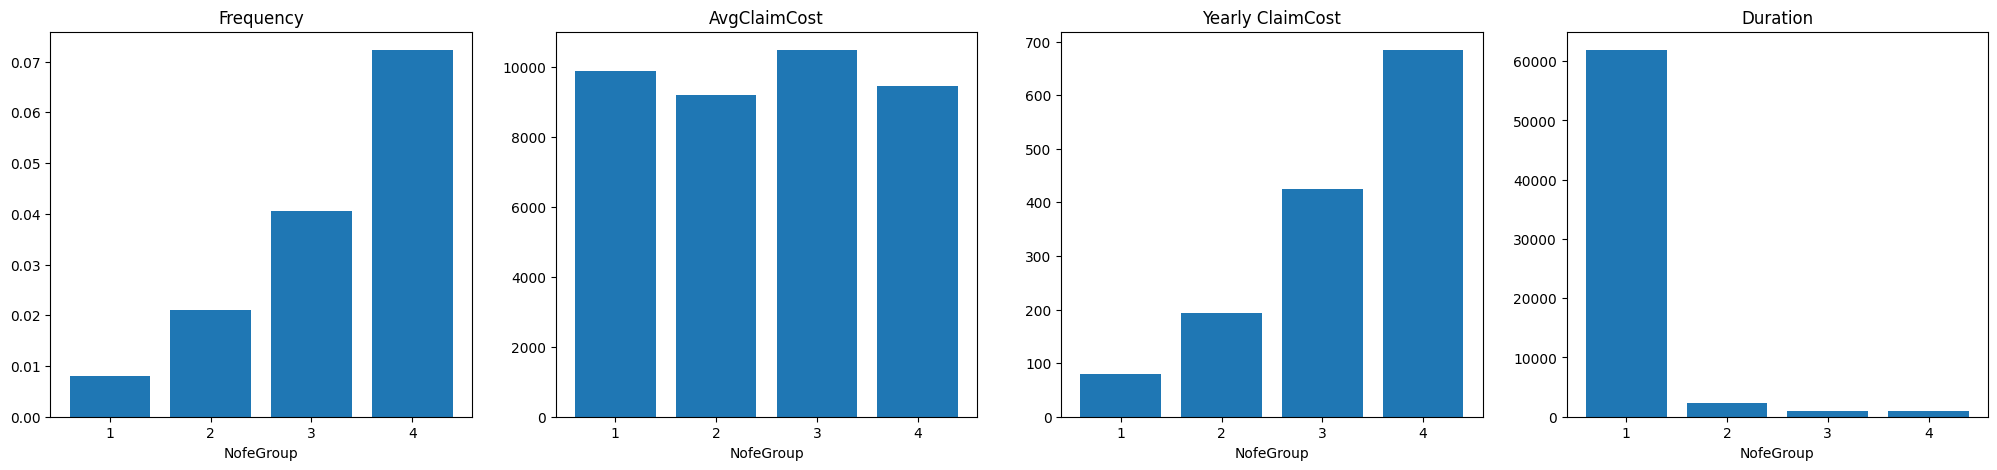

In [49]:
variable = "NumberOfFtEmployees"
grouped_variable_name = "NofeGroup"
bin_edges = [-np.inf, 30, 60, 100, np.inf]
bin_labels = [str(i) for i in range(1, len(bin_edges))]
# bin_edges = [-np.inf, 10, 100, np.inf]
# bin_labels = ["01. <10", "02. 10-100", "03. >100"]
# This part does the grouping based on the input above
df[grouped_variable_name] = pd.cut(
    df[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=False,  # Wheter to include the right edge in group or not
)
checkgroup("NofeGroup",df)

             NumberOfRows      Duration  NumberOfClaims   ClaimCost
TravelGroup                                                        
eu                   7780   3643.003107              29   244849.20
nordic              23982  11092.116393               9    64334.00
world              105131  51383.283554             622  6185364.63


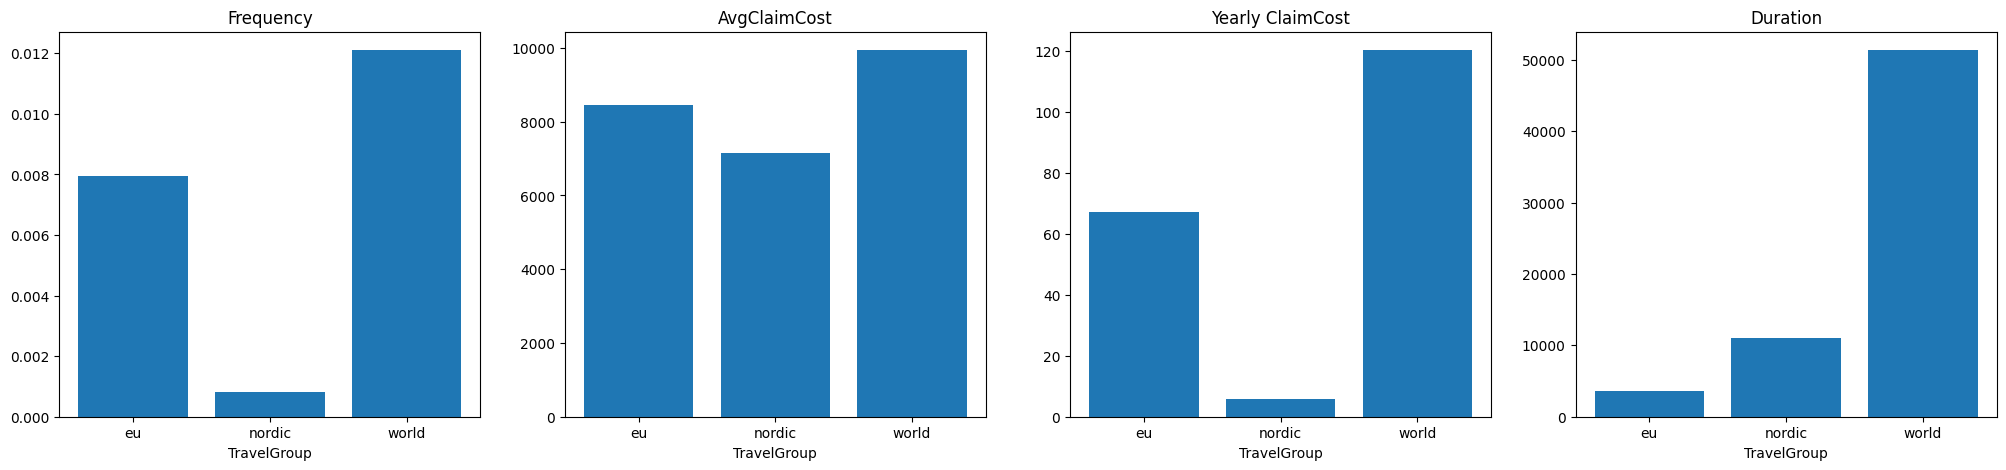

In [50]:
grouping_map = {
    "home" : "nordic",
}
df["TravelGroup"] = df["TravellingArea"].replace(grouping_map)
checkgroup("TravelGroup",df)

## Aggregate data and calculate avereage claim cost within each tariff cell

Secondly, we want to aggregate the data. That is, instead of having one row per company & year, we want one row for each existing combination of variables, that is, one row for each tariff cell.

This code aggregates columns for Duration, # of Claims & ClaimCost, by two variables: NoPGroup and ActivityGroup

The aggregated data is stored in a new table, df_agg

You need to consider if there are any other variables you want to aggregate by, and modify the code accordingly

In [51]:
fullvars = ["ActivityGroup", "NoPGroup", "FinGroup", "AgeGroup", "TravelGroup","NofeGroup"]  # The varaibles to use in the model
variables = fullvars
def agg(vars, data=df):
    df_agg = (
        data[vars + ["Duration", "NumberOfClaims", "ClaimCost"]]
        .groupby(vars)
        .agg("sum")
        .reset_index()
    )  # Aggregation to tariff cells
    df_agg["AvgClaimCost"] = df_agg["ClaimCost"] / df_agg["NumberOfClaims"]
    return df_agg

In [52]:
# Calculating the average claim cost within each tariff cell
df_agg = agg(fullvars)
# df_agg["AvgClaimCost"] = df_agg["ClaimCost"] / df_agg["NumberOfClaims"]

In [53]:
df_agg  # Display aggregated dataframe

,ActivityGroup,NoPGroup,FinGroup,AgeGroup,TravelGroup,NofeGroup,Duration,NumberOfClaims,ClaimCost,AvgClaimCost
0,Industry,01. <2,A,1,eu,1,57.730803,0,0.0,NaN
1,Industry,01. <2,A,1,eu,2,0.000000,0,0.0,NaN
2,Industry,01. <2,A,1,eu,3,0.000000,0,0.0,NaN
3,Industry,01. <2,A,1,eu,4,0.000000,0,0.0,NaN
4,Industry,01. <2,A,1,nordic,1,571.766974,0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
2587,Service,06. >=100,C,4,nordic,4,0.000000,0,0.0,NaN
2588,Service,06. >=100,C,4,world,1,0.000000,0,0.0,NaN
2589,Service,06. >=100,C,4,world,2,0.000000,0,0.0,NaN
2590,Service,06. >=100,C,4,world,3,0.000000,0,0.0,NaN


# GLM analysis
Now we get to the fun part - the GLM analysis

First we have some helping functions
* run_glm: takes in data, formula (target variable ~ variable1 + variable2 + ...), distribution and possible exposure or weight
* get_model_coefficients: takes in model and variable for which we want the model factors and the confidence intervals
* plot_model_results: uses get_model_coefficients to plot factors and confidence intervals

Then we run frequency model and severity model separately. Remember to use the same variables in both models.

## Functions

In [54]:
# Function for running glm using statsmodels glm-function
def run_glm(df, formula, family, exposure_col=None, weight_col=None):
    exposure = df[exposure_col] if exposure_col is not None else None
    weight = df[weight_col] if weight_col is not None else None
    model = glm(
        formula=formula,
        data=df,
        family=family,
        exposure=exposure,
        var_weights=weight,
        missing="raise",
    ).fit()
    return model

In [55]:
def get_model_coefficients(model, col_name, confidence_alpha=0.05):
    """Get coefficients from categorical variables"""
    coefs = np.exp(model.params[model.params.index.str.contains(col_name)])

    ref = coefs.index[-1]
    ref = re.sub(r".*?[\=]", "", ref, 1)
    ref = re.sub(r"[\)].*", "", ref)[1:-1]

    coefs.index = (
        coefs.index.str.replace(".*[\)]", "", regex=True)
        .str.replace("T.", "", regex=False)
        .str.replace("[", "", regex=False)
        .str.replace("]", "", regex=False)
    )
    coefs = coefs.append(pd.Series([1], index=[ref])).sort_index()

    conf_int = np.exp(
        model.conf_int(alpha=confidence_alpha, cols=None)[
            model.params.index.str.contains(col_name)
        ]
    )
    conf_int.index = (
        conf_int.index.str.replace(".*[\)]", "", regex=True)
        .str.replace("T.", "", regex=False)
        .str.replace("[", "", regex=False)
        .str.replace("]", "", regex=False)
    )
    lower = conf_int[0].append(pd.Series([1], index=[ref])).sort_index()
    upper = conf_int[1].append(pd.Series([1], index=[ref])).sort_index()

    return coefs, lower, upper


def plot_model_result(
    model, variable, model_type_name, conf_int=True, fig_size=(8, 8), return_fig=False
):
    coefs, lower, upper = get_model_coefficients(model, variable)

    fig = plt.figure(figsize=fig_size)
    plt.plot(coefs.index, coefs, label="risk")
    if conf_int:
        plt.plot(lower.index, lower, "g:", label="lower cofidence bound")
        plt.plot(upper.index, upper, "g:", label="upper confidence bound")
        plt.ylim(0, np.max(upper) + 0.1)
    plt.hlines(1, coefs.index[0], coefs.index[-1], linestyle="dotted", color="black")
    plt.xlabel(variable)
    plt.ylabel("Relative risk")
    plt.title(f"{model_type_name} factors for {variable}")
    plt.legend()
    if return_fig:
        return fig

## Frequency model
Here we use the Poisson distribution, NumberOfClaims as target and Duration as exposure measure to get the frequency

### Formula
The formula is on the form 'target variable ~ C(variable1,Treatment(reference="group name")) + ... '. As a starting point, the reference group can be chosen as the one with most duartion.

In [56]:
class model:
    def __init__(self, vars, groups, data) -> None:
        self.vars = vars
        self.data = data
       
        numvars = len(vars)
        if len(groups) != numvars:
            raise Exception
        self.groups = [v+"Group" for v in vars]
        self.varformula = dict()
        for i in range(numvars):
            groupname = self.groups[i]
            if groups[i] is None:
                self.data[groupname] = self.data[vars[i]]
            elif isinstance(groups[i], list):
                bin_labels = ["{}. {}-{}".format(j+1,groups[i][j],groups[i][j+1]) for j in range(len(groups[i])-1)]
                # This part does the grouping based on the input above
                self.data[groupname] = pd.cut(
                    data[vars[i]],
                    bins=groups[i],
                    labels=bin_labels,
                    right=False,  # Wheter to include the right edge in group or not
                )
            elif isinstance(groups[i] , dict):
                self.data[groupname] = self.data[vars[i]].replace(groups[i])
            else:
                raise Exception
        
        reference_groups = self.data[self.groups].mode()
        self.varformula = dict.fromkeys(self.groups)
        for groupname in self.varformula:
            self.varformula[groupname] = 'C({},Treatment(reference="{}"))'.format(groupname,reference_groups[groupname][0])
        self.agg = agg(self.groups, self.data)
        self.formula = 'NumberOfClaims ~ ' + '+'.join([self.varformula[g] for g in self.varformula])
        
        self.freqmodel()
        self.sevmodel()
        self.combine()
        # print(self.data)
    
    
    def freqmodel(self):
        frequency_family = (
            sm.families.Poisson()
        )  # For frequency model we use poisson distribution
        frequency_model = run_glm(
            self.agg[self.agg["Duration"]>0],
            self.formula,
            frequency_family,
            exposure_col="Duration",  # To get everything on yearly basis, we use Duration as exposure measure
        )
        self.freqmodel = frequency_model
        for var in self.groups:
            coefs = get_model_coefficients(self.freqmodel, var)[0]
            coefs.index.name = var
            coefs_df = pd.DataFrame(coefs, columns=[f"{var}_frequency_factor"])
            # print(coefs)
            self.data = self.data.merge(coefs_df, on=var)
        return self.freqmodel

    def sevmodel(self):
        link = sm.genmod.families.links.log()
        severity_family = sm.families.Gamma(link=link)  # For severity model we use
        severity_model = run_glm(
            self.agg[self.agg["AvgClaimCost"] > 0],
            self.formula,
            severity_family,
            weight_col="NumberOfClaims",  # For additional aggregation done by the model, the average number of claims need to be weighted by number of claims.
        )
        self.sevmodel = severity_model
        for var in self.groups:
            coefs = get_model_coefficients(self.sevmodel, var)[0]
            coefs.index.name = var
            coefs_df = pd.DataFrame(coefs, columns=[f"{var}_severity_factor"])
            self.data = self.data.merge(coefs_df, on=var)
        return self.sevmodel
    
    def plot_freq_factor(self):
        if not hasattr(self, "freqmodel"):
            self.freqmodel()
        for var in self.groups:
            plot_model_result(self.freqmodel, var, "Frequency")

    def plot_sev_factor(self):
        if not hasattr(self, "sevmodel"):
            self.sevmodel()
        for var in self.groups:
            plot_model_result(self.sevmodel, var, "Severity")
    
    def combine(self):
        for var in self.groups:
            self.data[f"{var}_factor"] = self.data[f"{var}_frequency_factor"] * self.data[f"{var}_severity_factor"]
        self.data.loc[:, "ModelPredictionFactor"] = 1
        for var in self.groups:
            self.data["ModelPredictionFactor"] *= self.data[f"{var}_factor"]
    def gini(self):
        giniscore = GiniScore(self.data, "Duration", "ClaimCost","ModelPredictionFactor") 
        return giniscore

    def plotcombine(self):
        for var in self.groups:
            df_plot = (
                self.data.groupby(
                    [var, f"{var}_frequency_factor", f"{var}_severity_factor", f"{var}_factor"]
                )
                .agg({"Duration": "sum"})
                .reset_index()
            )
            plt.figure(figsize=(20, 5))
            plt.subplot(131)
            plt.plot(df_plot[var], df_plot[f"{var}_frequency_factor"])
            plt.xlabel(var)
            plt.ylabel("Relative risk")
            plt.title("Frequency factor")
            plt.subplot(132)
            plt.plot(df_plot[var], df_plot[f"{var}_severity_factor"])
            plt.xlabel(var)
            plt.ylabel("Relative risk")
            plt.title("Severity factor")
            plt.subplot(133)
            plt.plot(df_plot[var], df_plot[f"{var}_factor"])
            plt.xlabel(var)
            plt.ylabel("Relative risk")
            plt.title("Final factor")
            plt.show()

In [57]:
varstr = {
    'NoPGroup':'C(NoPGroup,Treatment(reference="02. 2-4"))', 
    'ActivityGroup':'C(ActivityGroup,Treatment(reference="Other"))',
    'AgeGroup':'C(AgeGroup,Treatment(reference="01. <50"))', 
    'FinGroup':'C(FinGroup,Treatment(reference="A"))', 
    'TravelGroup':'C(TravelGroup,Treatment(reference="world"))', 
    'NofeGroup':'C(NofeGroup,Treatment(reference="01. <10"))', 
}
def freqmodel(vars):
    frequency_formula = 'NumberOfClaims ~ ' + '+'.join([varstr[v] for v in vars])
    frequency_family = (
        sm.families.Poisson()
    )  # For frequency model we use poisson distribution
    df_agg = agg(vars)
    frequency_model = run_glm(
        df_agg[df_agg["Duration"]>0],
        frequency_formula,
        frequency_family,
        exposure_col="Duration",  # To get everything on yearly basis, we use Duration as exposure measure
    )
    return frequency_model

def likelihood_ratio_test(logfm, logrm, df):
    from scipy.stats import chi2
    # chi2p005 = [0,3.84,5.99,7.81,9.49,11.07,12.59,14.07,15.51,16.92,18.31]
    return 1 - chi2.cdf(2*(logfm-logrm), df)

In [58]:
nopedge = [-np.inf, 2, 5, 15, 50, 100, np.inf]
cageedges = [-np.inf, 10, 30, 60, np.inf]
nofeedges= [-np.inf, 30, 60, 100, np.inf]
act_grouping_map = act_grouping_map = {
    "A": "Industry",
    "B": "Industry",
    "C": "Industry",
    "D": "Industry",
    "E": "Industry",
    "F": "Industry",
    "G": "Service",
    "H": "Service",
    "I": "Service",
    "J": "Other",
    "K": "Other",
    "L": "Other",
    "M": "Other",
    "N": "Other",
    "O": "Other",
    "P": "Other",
    "Q": "Service",
    "R": "Other",
    "S": "Service",
    "T": "Service",
    "U": "Industry",
    "X": "Industry",
    "Missing": "Industry",
}
finratemap = {
    "AAA" : "A",
    "AA" : "AA-B",
    "A" : "AA-B",
    "B" : "AA-B",
    "C" : "C",
    "AN": "C",
    "IR": "C",
    "Missing": "A",
}
travelmap={"home":"nordic"}
vars=["NumberOfPersons","ActivityCode","NumberOfFtEmployees", 'CompanyAge',
 'TravellingArea','FinancialRating']
vargroups=[nopedge,act_grouping_map,nofeedges,cageedges,travelmap,finratemap]



In [59]:

m1 = model(["NumberOfPersons","FinancialRating"], [nopedge,finratemap], data)
m2 = model(["ActivityCode","NumberOfPersons","FinancialRating"], [act_grouping_map,nopedge,finratemap], data)
print(m1.sevmodel.llf)
print(m2.sevmodel.llf)


-53.87769311857011
-108.8000166125461


In [60]:
m1 = model(["ActivityCode","NumberOfPersons"], [act_grouping_map,nopedge], data)
m3 = model(["ActivityCode","NumberOfPersons","FinancialRating"], [act_grouping_map,nopedge,finratemap], data)
m4 = model(["ActivityCode","NumberOfPersons","NumberOfFtEmployees"], [act_grouping_map,nopedge,nofeedges], data)
m2 = model(["ActivityCode","NumberOfPersons","CompanyAge"], [act_grouping_map,nopedge,cageedges], data)
m5 = model(["ActivityCode","NumberOfPersons","TravellingArea"], [act_grouping_map,nopedge,travelmap], data)
print(m1.sevmodel.aic)
print(m2.sevmodel.aic)
print(m3.sevmodel.aic)
print(m4.sevmodel.aic)
print(m5.sevmodel.aic)

134.8594442943823
313.23166019453254
237.6000332250922
236.23500392786917
178.9894402986368


In [61]:
# vars=["NumberOfPersons","ActivityCode","NumberOfFtEmployees", 'CompanyAge',
#  'TravellingArea','FinancialRating']
vars=["ActivityCode","CompanyAge","FinancialRating", 'NumberOfFtEmployees', 'NumberOfPersons','TravellingArea']
combs = pd.crosstab(vars,vars)
combs2 = pd.crosstab(vars,vars)
combs3 = pd.crosstab(vars,vars)
# vargroups=[nopedge,act_grouping_map,nofeedges,cageedges,travelmap,finratemap]
vargroups=[act_grouping_map,cageedges,finratemap,nofeedges,nopedge,travelmap]
for i in range(len(vars)):
    for j in range(len(vars)):
        if i>j:
            m = model([vars[i],vars[j]], [vargroups[i],vargroups[j]], df)
            # print(vars[i],vars[j], m.gini())
            combs.loc[vars[i],vars[j]] = m.gini()
            combs2.loc[vars[i],vars[j]] = str(m.freqmodel.aic) + " / " + str(m.sevmodel.aic)
            combs3.loc[vars[i],vars[j]] = str(m.freqmodel.bic) + " / " + str(m.sevmodel.bic)
        else:
            combs.loc[vars[i],vars[j]]=''
            combs2.loc[vars[i],vars[j]]=""
            combs3.loc[vars[i],vars[j]]=""

# fm = freqmodel(["ActivityGroup", "NoPGroup", "FinGroup"])
# likelihood_ratio_test(fm.llf, rm.llf, 1)


In [62]:
print(combs3.to_latex())

\begin{tabular}{lllllll}
\toprule
col\_0 &                             ActivityCode &                                CompanyAge &                           FinancialRating &                       NumberOfFtEmployees &                           NumberOfPersons & TravellingArea \\
row\_0               &                                          &                                           &                                           &                                           &                                           &                \\
\midrule
ActivityCode        &                                          &                                           &                                           &                                           &                                           &                \\
CompanyAge          &  14.166255201894295 / 31.554138343238307 &                                           &                                           &                                        

In [63]:
combs2

col_0,ActivityCode,CompanyAge,FinancialRating,NumberOfFtEmployees,NumberOfPersons,TravellingArea
row_0,,,,,,
ActivityCode,,,,,,
CompanyAge,99.98086423976862 / 100.77198859002016,,,,,
FinancialRating,62.83113952794434 / 68.18397253967937,64.55119207973328 / 85.19956376884232,,,,
NumberOfFtEmployees,105.71591169771133 / 91.73069156523138,158.68256886729003 / 120.43235739228824,63.90972331619744 / 60.59774435877496,,,
NumberOfPersons,169.78724935423878 / 134.8594442943824,171.04385094084455 / 156.6978480424324,122.10673376271512 / 123.75538623714021,143.22654873664314 / 122.97588501933669,,
TravellingArea,53.8784296159768 / 44.36196369163967,55.61259444899925 / 55.742499481895194,51.429403152133034 / 55.876223857878145,53.28575777008109 / 35.14217139638646,97.17896945369877 / 87.95464572680228,


In [64]:
combs3

col_0,ActivityCode,CompanyAge,FinancialRating,NumberOfFtEmployees,NumberOfPersons,TravellingArea
row_0,,,,,,
ActivityCode,,,,,,
CompanyAge,14.166255201894295 / 31.554138343238307,,,,,
FinancialRating,-3.34880918031552 / -0.2198710494455014,-14.162629320830138 / 9.08874815154759,,,,
NumberOfFtEmployees,19.018213887339748 / 5.635808645738415,56.42957765090462 / 58.21810505579694,-11.457339667004193 / -4.177235762469797,,,
NumberOfPersons,33.94089024693891 / 0.5116685920492259,8.151641496792273 / 23.543255110286346,2.2083738010986558 / 24.599342147791806,7.569404975857275 / 41.30440964593277,,
TravellingArea,-6.053177771845306 / -4.668571090001834,-12.989900257958764 / -3.085237430953645,-4.572302481604235 / -2.8200416768583203,-10.713361880128126 / -1.809558807195515,-14.805165374184515 / -7.298277368803719,


In [65]:
# Plot model factors and confidence intervals
def plotfactor(model, vars, model_type_name):
    global df
    for var in vars:
        coefs = get_model_coefficients(model, var)[0]
        coefs.index.name = var
        coefs_df = pd.DataFrame(coefs, columns=[f"{var}_{model_type_name.lower()}_factor"])
        df = df.merge(coefs_df, on=var)

        plot_model_result(model, var, model_type_name)


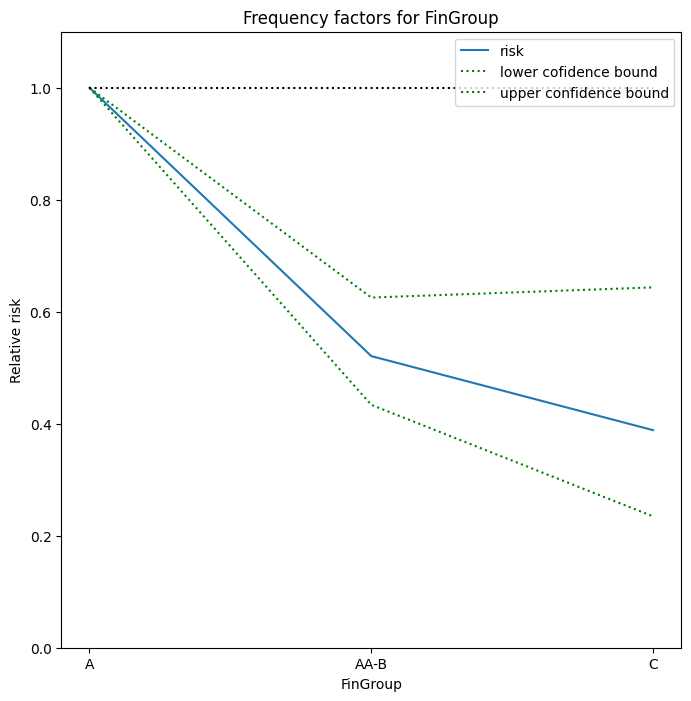

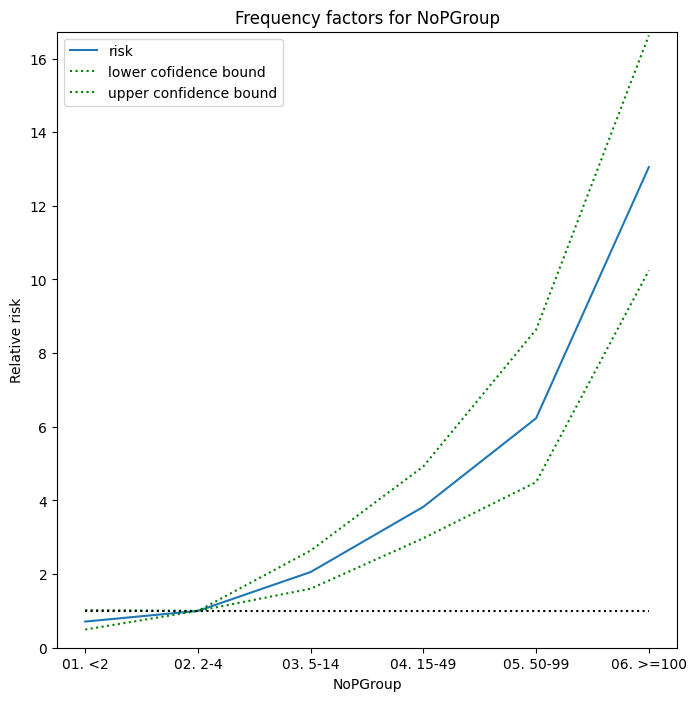

In [66]:
variables = ["FinGroup","NoPGroup"]
fullfreq = freqmodel(variables)
plotfactor(fullfreq, variables, "Frequency")

## Severity model
Here we use the Gamma distribution with a log link, average claim cost as target and number of claims as weight

In [67]:
def sevmodel(vars):
    severity_formula = 'NumberOfClaims ~ ' + '+'.join([varstr[v] for v in vars])
    link = sm.genmod.families.links.log()
    severity_family = sm.families.Gamma(link=link)  # For severity model we use
    df_agg = agg(vars)
    severity_model = run_glm(
    df_agg[df_agg["AvgClaimCost"] > 0],
        severity_formula,
        severity_family,
        weight_col="NumberOfClaims",  # For additional aggregation done by the model, the average number of claims need to be weighted by number of claims.
    )
    return severity_model

In [68]:
fullsev = sevmodel(variables)
fullsev.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         NumberOfClaims   No. Observations:                   15
Model:                            GLM   Df Residuals:                        7
Model Family:                   Gamma   Df Model:                            7
Link Function:                    log   Scale:                          4.2533
Method:                          IRLS   Log-Likelihood:                -53.878
Date:                Mon, 06 Mar 2023   Deviance:                       43.556
Time:                        21:27:34   Pearson chi2:                     29.8
No. Iterations:                    16   Pseudo R-squ. (CS):             0.9717
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    4.3669      0.214     20.396      0.000       3.947       4.787
C(FinGroup, Treatment(reference="A"))[T.AA-B]               -0.8323      0.194     -4.301      0.000      -1.212      -0.453
C(FinGroup, Treatment(reference="A"))[T.C]                  -1.9543      0.548     -3.565      0.000      -3.029      -0.880
C(NoPGroup, Treatment(reference="02. 2-4"))[T.01. <2]       -0.9462      0.388     -2.437      0.015      -1.707      -0.185
C(NoPGroup, Treatment(reference="02. 2-4"))[T.03. 5-14]      0.1658      0.264      0.627      0.530      -0.352       0.684
C(NoPGroup, Treatment(reference="02. 2-4"))[T.04. 15-49]     0.1698      0.267      0.637      0.524      -0.353       0.693
C(NoPGroup, Treatment(reference="02. 2-4"))[T.05. 50-99]    -0.4843      0.351     -1.381      0.167      -1.171       0.203
C(NoPGroup, Treatment(reference="02. 2-4"))[T.06. >=100]     0.5834      0.255      2.284      0.022       0.083       1.084
============================================================================================================================
"""

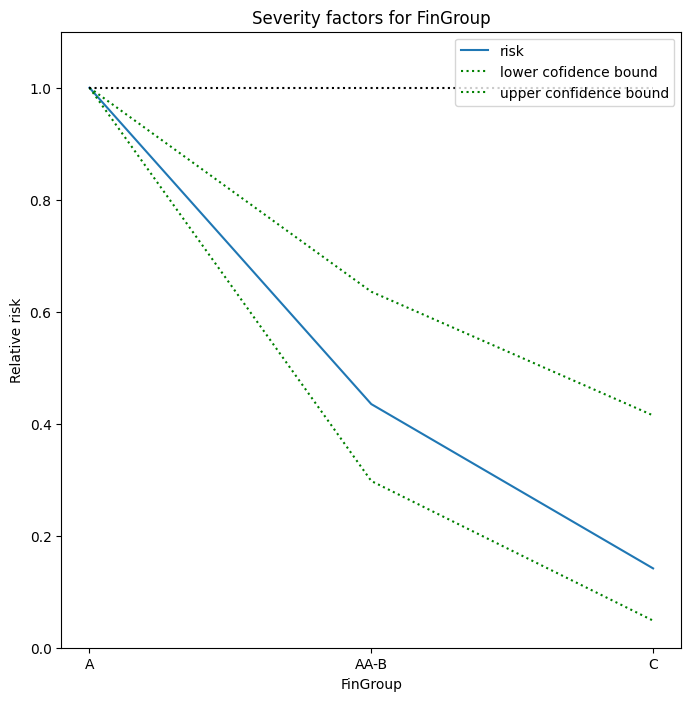

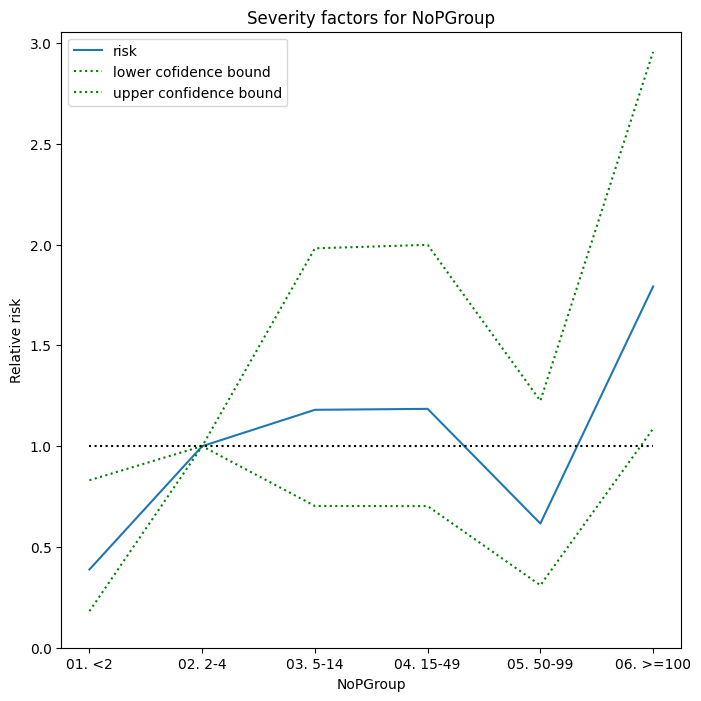

In [69]:
plotfactor(fullsev, variables, "Severity")

## Combine models
When you are satisfied with the outputs from the severity and the frequency models, you should combine them to get the final variable factor, and in the end combine all variable factors to get the final model factor

In [70]:
# For each variable used in the model, the factors from the frequency model and the factors from the severity model are multiplied
for var in variables:
    df[f"{var}_factor"] = df[f"{var}_frequency_factor"] * df[f"{var}_severity_factor"]

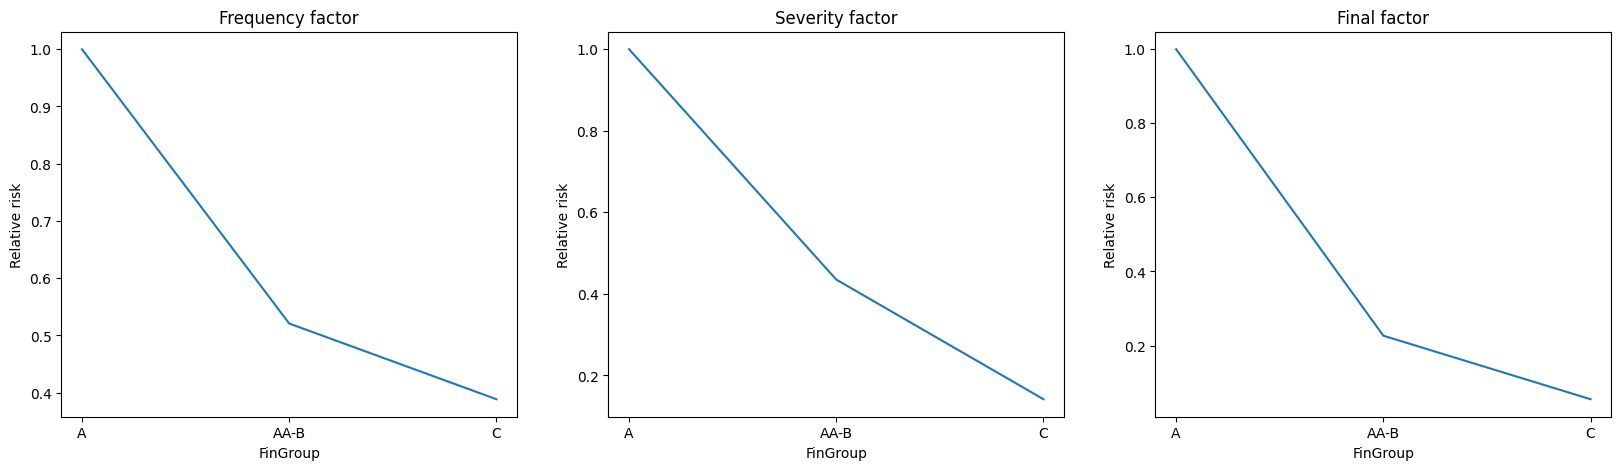

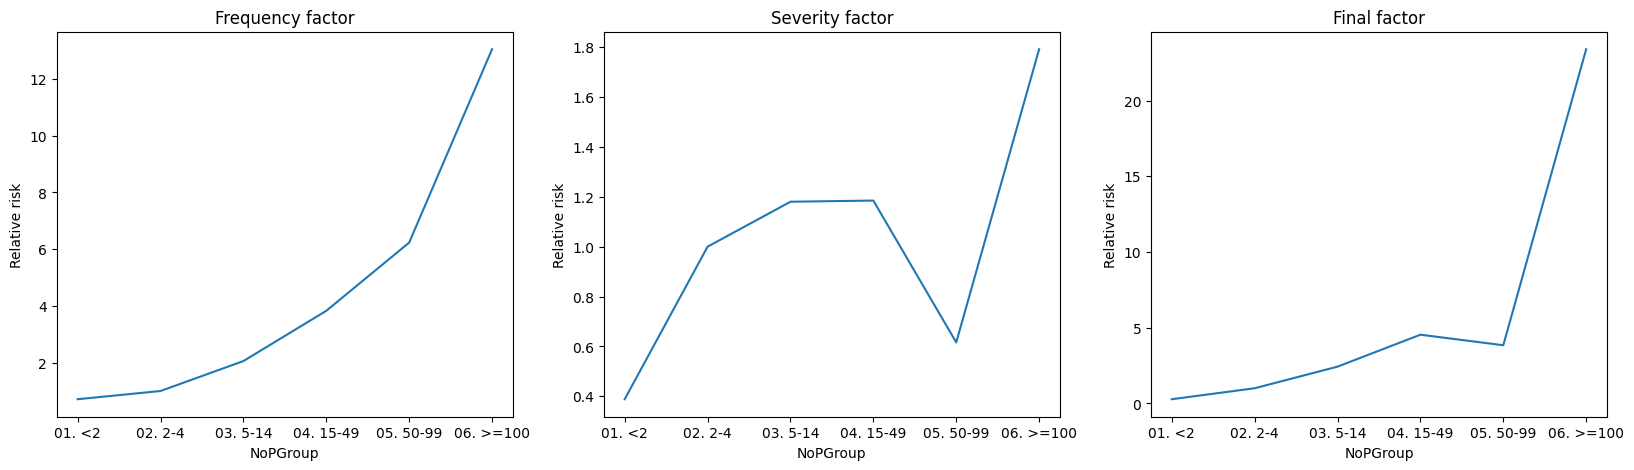

In [71]:
# For each variable used in the model we can plot the factors from the frequency, severity and final variable factor
for var in variables:
    df_plot = (
        df.groupby(
            [var, f"{var}_frequency_factor", f"{var}_severity_factor", f"{var}_factor"]
        )
        .agg({"Duration": "sum"})
        .reset_index()
    )
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.plot(df_plot[var], df_plot[f"{var}_frequency_factor"])
    plt.xlabel(var)
    plt.ylabel("Relative risk")
    plt.title("Frequency factor")
    plt.subplot(132)
    plt.plot(df_plot[var], df_plot[f"{var}_severity_factor"])
    plt.xlabel(var)
    plt.ylabel("Relative risk")
    plt.title("Severity factor")
    plt.subplot(133)
    plt.plot(df_plot[var], df_plot[f"{var}_factor"])
    plt.xlabel(var)
    plt.ylabel("Relative risk")
    plt.title("Final factor")
    plt.show()

In [72]:
df.loc[:, "ModelPredictionFactor"] = 1

In [73]:
# In the end, the factors from each varaible are multiplied to get the final differentiating factor
df.loc[:, "ModelPredictionFactor"] = 1
for var in variables:
    df["ModelPredictionFactor"] *= df[f"{var}_factor"]

# Model validation

## Gini validation
For each model we can create a Lorenz curve and get a gini score. The gini score is a good measure of how well the model risk asses the different tariff cells relatively to each other. 

Below there are help functions to
* Create a lorenz curve
* Create a gini score
* Create a gini plot with the help of the two above

In [74]:
def lorentz_curve(x, y, sort_by):
    assert x.shape == y.shape
    df_l2 = (
        pd.DataFrame(data={"x": x, "y": y, "sort_by": sort_by})
        .groupby(["sort_by"], as_index=False)
        .sum()
    )
    x_no_ties = df_l2["x"]
    y_no_ties = df_l2["y"]
    sort_by_no_ties = df_l2["sort_by"]
    sort = np.argsort(sort_by_no_ties)
    x_cumsum = pd.concat(
        [pd.Series([0]), x_no_ties.iloc[sort].cumsum() / x_no_ties.sum()]
    )
    y_cumsum = pd.concat(
        [pd.Series([0]), y_no_ties.iloc[sort].cumsum() / y_no_ties.sum()]
    )
    lorentz = np.trapz(x=x_cumsum, y=y_cumsum)
    diag = np.trapz(x=x_cumsum, y=x_cumsum)
    area_between_curves = diag - lorentz
    return area_between_curves, x_cumsum, y_cumsum


def GiniScore(df, x, y, sort_by):
    oracle_area, oracle_x, oracle_y = lorentz_curve(
        df[x], df[y], df[y] / df[x]
    )  # perfect order
    area, x_cumsum, y_cumsum = lorentz_curve(
        df[x], df[y], df[sort_by]
    )  # prediction order
    gini = area / oracle_area  # area relative perfect area
    return gini


def CreateGiniPlot(df, x, y, i="", figsize=(8, 6)):
    oracle_area, oracle_x, oracle_y = lorentz_curve(df[x], df[y], df[y] / df[x])

    fig = plt.figure(figsize=figsize)

    plt.plot(oracle_x, oracle_y, label=f"Sorted by {y}, perfect model")
    plt.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        color="black",
        label="Random baseline " + i + " (Gini {:.3f})".format(0),
    )

    plt.xlabel(
        "Fraction of total "
        + df[x].name
        + "\n"
        + "(ordered by model from safest to riskiest)"
    )
    plt.ylabel("Fraction of total " + df[y].name)

    def AddGiniModel(sort_by):

        area, x_cumsum, y_cumsum = lorentz_curve(df[x], df[y], df[sort_by])
        plt.plot(
            x_cumsum,
            y_cumsum,
            label=f"Sorted by {df[sort_by].name} (NormGini {area/oracle_area:.3f})",
        )

        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(loc="upper left")

        gini = area / oracle_area
        return gini

    return AddGiniModel, fig

In [75]:
GiniScore(df, "Duration", "ClaimCost", "ModelPredictionFactor")

0.6488974421004088

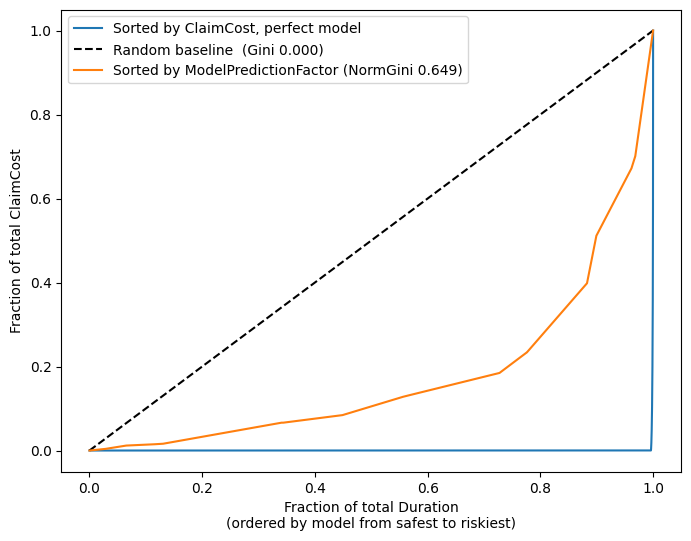

In [76]:
gini, fig = CreateGiniPlot(
    df, "Duration", "ClaimCost"
)  # creates base line and lorenz curve for perfect model (ordered by claim cost which is the actual outcome)
gini_index = gini("ModelPredictionFactor")  # Ordered by your model
plt.show()

### Compare models with gini
It is possible to add two models to the same gini plot to compare them.

Below is an example where a second model (that only prices based on NumberOfPersons - the higher value, the higher price) is added to the gini plot to compare to the first model. 

Note that the NumberOfPersons-model looks best in this case and this can have several reasons. One is that it is more differentiated, since the number of persons are not grouped. When grouping numerical variables, the final factor curve is normally piecewise linear, with the linear parts being interpolations between the model factors. Using the Duration-weighted average value of the variable in each group as the knots for the model factors, try to make an interpolated model and evaluate this instead.

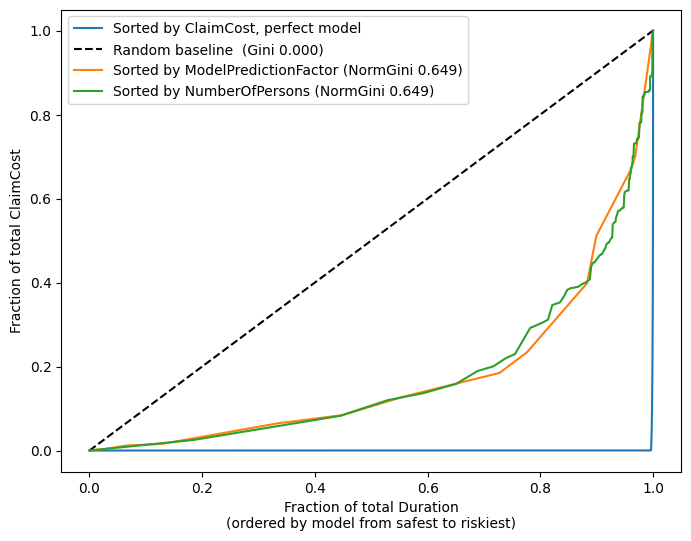

In [77]:
gini, fig = CreateGiniPlot(
    df, "Duration", "ClaimCost"
)  # creates base line and lorenz curve for perfect model (ordered by claim cost which is the actual outcome)
gini_index = gini("ModelPredictionFactor")  # Ordered by your model
gini_index_2 = gini("NumberOfPersons")  # Ordered by your second model
plt.show()

## Risk ratio validation
Gini score only takes into account the relative risk between tariff cells. To see if the magnitude is correct, we can use other tests, for example risk ratio validation.

The goal here is to see an even risk ratio between groups, or at least more even than a random model, or that the model you are testing against.

We are here testing between groups in the variables used in the model, but any variables in the data can be used to test on.

Below, we calculate a random claim cost for each customer based on the total claim cost and the duration, and a predicted claim cost based on the model prediction, duration and total claim cost. Based on this set-up the target risk ratio is 1.

Note that above, the gini was better for a model only based on number of persons, but below when assuming a model that prices linearly on number of persons, the risk ratio becomes very uneven between groups, and our glm model performs much better.

In [78]:
# Calculating random claim cost, and claim cost prediction
total_claim_cost = df["ClaimCost"].sum()
total_duration = df["Duration"].sum()
total_model_factor = (df["ModelPredictionFactor"] * df["Duration"]).sum()
total_model_factor_nop = (df["NumberOfPersons"] * df["Duration"]).sum()
df["random_claim_cost"] = df["Duration"] * total_claim_cost / total_duration
df["predicted_claim_cost"] = (
    df["ModelPredictionFactor"] * df["Duration"] * total_claim_cost / total_model_factor
)
df["predicted_claim_cost_nop"] = (
    df["NumberOfPersons"] * df["Duration"] * total_claim_cost / total_model_factor_nop
)

In [79]:
df["predicted_claim_cost_nop"].sum()-total_claim_cost

-1.862645149230957e-09

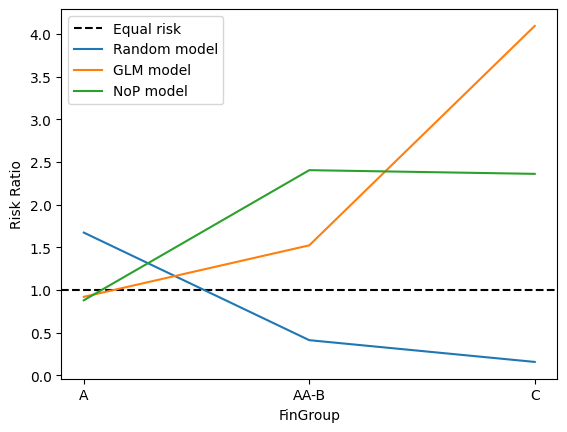

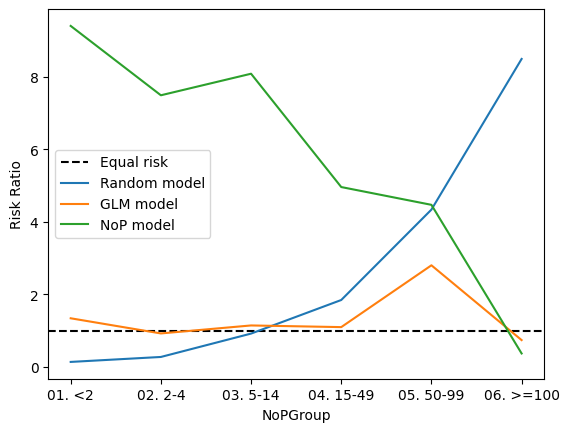

In [80]:
# Aggregating per grouped variable and plotting
agg_dict = {
    "ClaimCost": "sum",
    "random_claim_cost": "sum",
    "predicted_claim_cost": "sum",
    "predicted_claim_cost_nop": "sum"
}
for var in variables:
    df_rr_agg = df.groupby(var).agg(agg_dict)
    fig, ax = plt.subplots()
    ax.axhline(1, color="k", linestyle="dashed", label="Equal risk")
    plt.plot(
        df_rr_agg.index,
        df_rr_agg["ClaimCost"] / df_rr_agg["random_claim_cost"],
        label="Random model",
    )
    plt.plot(
        df_rr_agg.index,
        df_rr_agg["ClaimCost"] / df_rr_agg["predicted_claim_cost"],
        label="GLM model",
    )
    plt.plot(
        df_rr_agg.index,
        df_rr_agg["ClaimCost"] / df_rr_agg["predicted_claim_cost_nop"],
        label="NoP model",
    )
    plt.xlabel(df_rr_agg.index.name)
    plt.ylabel("Risk Ratio")
    plt.legend()
    plt.show()

# Leveling
Now that you hav your model factors it is time to set a base level, that is the price that the factors will be multiplied with to get a price.

Here, you need to decide what claim cost to use to calculate the base level for your pricing model. Below is an example where all claim cost in the data set is used. This is not the best way to do it, so think about how you would like to do this.

In [81]:
active = df[df["RiskYear"]<2019]
total_claim_cost = active["ClaimCost"].sum()
target_risk_ratio = 0.9
total_model_factor = (active["ModelPredictionFactor"] * active["Duration"]).sum()
base_level = total_claim_cost / (0.9 * total_model_factor)
df["premium"] = base_level * df["Duration"] * df["ModelPredictionFactor"]

In [82]:
base_level

46.69998459348662